# Data preparation

In [7]:
from lib import * # wrime data is loaded here.

In [8]:
# The column of "Avg. Readers_*" ex extraceted as a dataframe object. 
df_wrime_features = df_wrime_target.loc[:, 'Avg. Readers_Joy':'Avg. Readers_Trust']

df_wrime_features.info() # なぜ平均なのにint型？ これはどうしてか？

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Avg. Readers_Joy           18237 non-null  int64
 1   Avg. Readers_Sadness       18237 non-null  int64
 2   Avg. Readers_Anticipation  18237 non-null  int64
 3   Avg. Readers_Surprise      18237 non-null  int64
 4   Avg. Readers_Anger         18237 non-null  int64
 5   Avg. Readers_Fear          18237 non-null  int64
 6   Avg. Readers_Disgust       18237 non-null  int64
 7   Avg. Readers_Trust         18237 non-null  int64
dtypes: int64(8)
memory usage: 1.1 MB


## Normalization

In [9]:
# This part is not adopted.
"""
from sklearn import preprocessing

# 正規化 (optional)
mm = preprocessing.MinMaxScaler()
df_wrime_features= pd.DataFrame(mm.fit_transform(df_wrime_features), columns=df_wrime_features.columns)
df_wrime_features.info()
"""

'\nfrom sklearn import preprocessing\n\n# 正規化 (optional)\nmm = preprocessing.MinMaxScaler()\ndf_wrime_features= pd.DataFrame(mm.fit_transform(df_wrime_features), columns=df_wrime_features.columns)\ndf_wrime_features.info()\n'

# Clustering

In [10]:
from sklearn.cluster import KMeans

k = 6 # num. of clusters.
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_wrime_features) # Execusion of k-means clustering. 
clusters = kmeansModel.labels_ # cluster IDs. 
clusters = clusters + 1 # cluster IDs are 1-based. 


/home/om/.miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [11]:
# Rename cluster IDs

clusters[clusters == 3] = -1
clusters[clusters == 4] = -2
clusters[clusters == 2] = -3
clusters[clusters == 6] = -4
clusters[clusters == 1] = -5
clusters[clusters == 5] = -6

for id in range(1,7):
    clusters[clusters == -id] = id

In [12]:
df_wrime_features_clusters = df_wrime_features.copy()
df_wrime_features_clusters['cluster'] = clusters
# Save the clusters. This will be used in further analysis.
_dir = "clusters"
if not os.path.isdir(_dir):
    os.makedirs(_dir)
df_wrime_features_clusters['cluster'].to_csv(os.path.join(_dir, 'emotion_6_clusters.tsv'), sep='\t', header=False, index=None)

In [13]:
# cmap is defined in lib.py
colors = cmap(np.linspace(0, 1, k)) # Global variable:

cols = df_wrime_features.columns

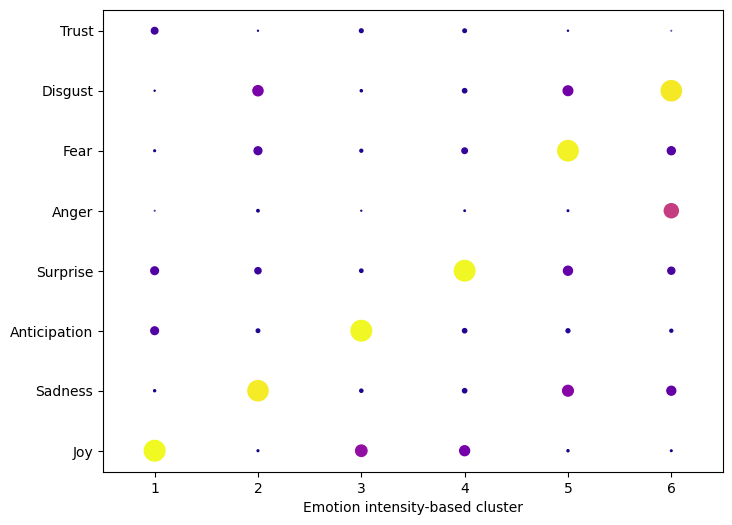

In [14]:
def scatter_bet_8_emotions_and_intensity_based_clusters(cols):
    x = []
    y = []
    targets = []
    # colors = []
    for i, col in enumerate(cols):
        for j in range(k+1):
            target_value = df_wrime_features_clusters[df_wrime_features_clusters['cluster']==j][col].mean()
            x.append(j)
            y.append(i)
            #targets.append(np.exp(1+target_value*3/2))
            targets.append(target_value*100)

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(x, y, s=targets, c=targets, cmap='plasma')
    plt.xticks(list(range(k+1)), list(range(k+1)))
    plt.yticks(list(range(len(cols))), emotion_names)
    ax.set_xlim(+0.5, k+0.5)
    plt.xlabel('Emotion intensity-based cluster')
    plt.show()
    
scatter_bet_8_emotions_and_intensity_based_clusters(cols)

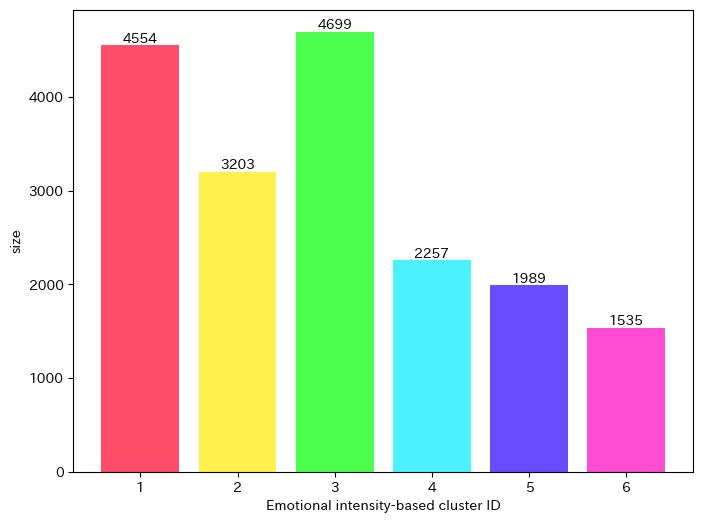

In [15]:


def bar_graph_of_intensity_based_clusters():
    # Japanese font setting. 
    font_manager.fontManager.addfont('fonts/ipaexg.ttf')
    matplotlib.rc('font', family="IPAexGothic")

    # Size of each cluster. 
    cluster_IDs, counts = np.unique(clusters, return_counts=True)

    # Visualization. 
    plt.figure(figsize=(8, 6))
    bars = plt.bar(cluster_IDs, counts, color=colors, alpha=0.7)
    plt.xlabel('Emotional intensity-based cluster ID')
    # plt.ylabel('count')
    plt.ylabel('size')
    # plt.title(f'cluster size(k={k})')
    plt.xticks(cluster_IDs)

    # Display texts. 
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

    plt.show()

    return cluster_IDs

cluster_IDs = bar_graph_of_intensity_based_clusters()



# Visualization of embedding vectors. 

In [16]:

df_wrime_features_tsne, df_wrime_features_umap = appy_dimensionality_reduction(df_wrime_features, clusters)


In [ ]:
### First, fix an emotion of the eight categories. Second, each tweet is colored according to the emotion's intensity. 
# 
# 
# 
# # # Visualization of UMAP
# plt.figure(figsize=(4, 3))
# plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
# plt.title(f'UMAP (k={k})')
# plt.colorbar()
# plt.show()


fig = plt.figure(figsize=(6,13))
for i, col in enumerate(cols):
    ax = fig.add_subplot(4, 2, i+1, title=emotion_names[i])
    sc = ax.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1],
                    c=df_wrime_features[col], cmap='plasma', alpha=0.7)
fig.tight_layout()
fig.colorbar(sc, ax=fig.axes, orientation='horizontal', fraction=0.1, pad=0.03, label='intensity')

plt.show()

### Average and standard deviation of each intensity-based cluster

In [ ]:
# Average of each emotion category in each intensity-based cluster
df_wrime_features_clusters.groupby(clusters).mean()

In [ ]:
# Standard deviation of each emotion category in each intensity-based cluster
df_wrime_features_clusters.groupby(clusters).std()

In [ ]:
for i in range(k):
    fig, ax = plt.subplots(figsize=(8, 4))
    row_data_mean = df_wrime_features_clusters.groupby(clusters).mean().iloc[i, :] # average
    row_data_std = df_wrime_features_clusters.groupby(clusters).std().iloc[i, :] # standard deviation
    cluster_label = i + 1

    # columns 
    cluster_data_mean = row_data_mean.drop('cluster')
    cluster_data_std = row_data_std.drop('cluster')
    column_names = cluster_data_mean.index.tolist()
    column_values = cluster_data_mean.values.tolist()
    column_values_std = cluster_data_std.values.tolist()

    # bar graph with error bars
    ax.bar(emotion_names, column_values, yerr=column_values_std, ecolor='black', error_kw={'elinewidth': 1, 'capsize': 3})
    ax.set_title(f'Cluster {cluster_label}')
    ax.set_ylim(0, 3.0)

    plt.tight_layout()
    plt.show()

### Finding the optimal cluster size

In [ ]:
k_max=41

### The elbow method is a unsupervised learning method used in K-means clustering. 
It compares the difference of the sum of square error (SSE) of each cluster, the most extreme difference forming the angle of the elbow shows the best cluster number.

In [ ]:
from sklearn.cluster import KMeans

# Survey of optimal number of clusters by Elbow Method
SSE = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, n_init='auto', random_state=0).fit(df_wrime_features)
    SSE.append(kmeans_model.inertia_)

# Visualization
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), SSE, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('SSE')
plt.title('Survey of optimal number of clusters by Elbow Method')
plt.grid(True)
plt.show()


### Calculation of silhouette  

In [ ]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Survey of optimal number of clusters by Silhouette Coefficient
silhouette_coefficients = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, n_init='auto', random_state=0).fit(df_wrime_features)
    silhouette_coefficient = silhouette_score(df_wrime_features, kmeans_model.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# Visualization
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('Silhouette Coefficient')
plt.title('Survey of optimal number of clusters by Silhouette Coefficient')
plt.grid(True)
plt.show()


# Davies-Bouldin Index

In [ ]:
from sklearn.metrics import davies_bouldin_score

dbi = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, n_init='auto', random_state=0).fit(df_wrime_features)
    dbi.append(davies_bouldin_score(df_wrime_features, kmeans_model.labels_))

# Visualization
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), dbi, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('Davies-Bouldin Index')
plt.title('Survey of optimal number of clusters by Davies-Bouldin Index')
plt.grid(True)
plt.show()

### Plot showing silhouette scores

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# silhouette score of all samples
silhouette_avg = silhouette_score(df_wrime_features, clusters)

# silhouette score of each sample
silhouette_values = silhouette_samples(df_wrime_features, clusters)

# Visualization
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(cluster_IDs):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i+1))
    y_lower = y_upper + 10

# vertical broken line representing the average silhouette score 
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"average: {silhouette_avg:.3f}", color="red")

plt.xlabel('Silhouette Coefficient')
plt.ylabel('Intensity-based cluster ID (inside y-axis)')
plt.title(f'Silhouette Plot (k={k})')
plt.show()

# 吉永君，外側のy軸は何を表しているのか？

In [ ]:
# The tweet with the highest silhouette coefficient in each intensity-based cluster
for i, cluster in enumerate(cluster_IDs):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'Intensity-based cluster ID: {clusters[index]}')
    print(f'The highest scored tweet: {df_wrime_target.iloc[index, 0]}')
    print(f'Silhouette score: {cluster_silhouette_values[-1]:.3f}')
    print('---')